# Toast data analysis and curation

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/perfect-toast-machine/blob/master/ptm_feature_selection_and_dataset_curation.ipynb)

Downloads data from GitHub repository into */content/dataset*, analyzes it, standardizes it, creates an Edge Impulse ready set of CSV files, and trains a NN to test viability. It also performs feature importance ranking using LASSO and lets you choose which features to keep.

## Step 1: Load the data

In [ ]:
import csv
import os
import shutil
import random
import uuid

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

In [ ]:
### Settings
HOME_PATH = "/content"              # Location of the working directory
DATASET_PATH = "/content/dataset"   # Upload your .csv samples to this directory
OUT_PATH = "/content/out"           # Where output files go (will be deleted and recreated)
TRAIN_DIR = "training"              # Where to store training output files
TEST_DIR = "testing"                # Where to store testing output files
OUT_ZIP = "/content/out.zip"        # Where to store the zipped output files
X_WINDOW_LEN = 20                   # Number of samples in the window
X_WINDOW_STRIDE = 2                 # Number of samples to skip for the next window
Y_SCALE = 1000                      # Divide y values by this amount (convert ms to sec)

# Set aside 20% for test
TEST_RATIO = 0.2

# Hardcoded column index
TIME_IDX = 0                        # Column number of the timestamp data
TEMP_IDX = 1                        # Column number of the temperature data
HUMD_IDX = 2                        # Column number of the humidity data
PRES_IDX = 3                        # Column number of the pressure data
CO2_IDX = 4                         # Column number of the CO2 data
VOC1_IDX = 5                        # Column number of the VOC1 data
VOC2_IDX = 6                        # Column number of the VOC2 data
NO2_IDX = 7                         # Column number of the NO2 data
ETH_IDX = 8                         # Column number of the ethanol data
CO_IDX = 9                          # Column number of the CO data
NH3_IDX = 10                        # Column number of the ammonia data
STATE_IDX = 11                      # Column number of the state data

# Burnt state index
BURNT_STATE_NUM = 3                 # The state that we care about

# Seed for pseudorandomness 
SEED = 42

In [ ]:
### Download data

url = "https://github.com/ShawnHymel/perfect-toast-machine/raw/main/datasets/burnt-toast-dataset.zip"
filename = "burnt-toast-dataset.zip"
filepath = os.path.join(HOME_PATH, filename)

# Start with fresh dataset directory
if os.path.exists(DATASET_PATH):
  shutil.rmtree(DATASET_PATH)
os.makedirs(DATASET_PATH)

# Download zip file
!wget {url}

# Unzip
!unzip -q {filepath} -d {DATASET_PATH}

--2022-10-09 18:08:01--  https://github.com/ShawnHymel/perfect-toast-machine/raw/main/datasets/burnt-toast-dataset.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ShawnHymel/perfect-toast-machine/main/datasets/burnt-toast-dataset.zip [following]
--2022-10-09 18:08:01--  https://raw.githubusercontent.com/ShawnHymel/perfect-toast-machine/main/datasets/burnt-toast-dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 266888 (261K) [application/zip]
Saving to: ‘burnt-toast-dataset.zip’

burnt-toast-dataset 100%[===================>] 260.63K  --.-KB/s    in 0.02s   

2022-10-09 18:08:02

In [ ]:
### Flatten the dataset directory
for dir in os.listdir(DATASET_PATH):
  dirpath = os.path.join(DATASET_PATH, dir)
  if os.path.isdir(dirpath):
    for filename in os.listdir(dirpath):
      shutil.move(os.path.join(dirpath, filename), os.path.join(DATASET_PATH, filename))
    shutil.rmtree(dirpath)

In [ ]:
### Read in .csv files

# Store header, raw data, and number of lines found in each .csv file
header = None
raw_data = []
filenames = []

# Read each CSV file
for filename in os.listdir(DATASET_PATH):

  sample_data = []

  # Check if the path is a file
  filepath = os.path.join(DATASET_PATH, filename)
  if not os.path.isfile(filepath):
    continue

  # Read the .csv file
  with open(filepath) as f:
    csv_reader = csv.reader(f, delimiter=',')

    # Read each line
    valid_line_counter = 0
    for line_count, line in enumerate(csv_reader):

      # Check header
      if line_count == 0:

        # Record first header as our official header for all the data
        if header == None:
          header = line

        # Check to make sure subsequent headers match the original header
        if header == line:
          filenames.append(filename)
        else:
          print("Error: Headers do not match. Skipping", filename)
          break

      # Construct raw data array, make sure number of elements match number of header labels
      else:
        if len(line) == len(header):
          sample_data.append(line)
        else:
          print("Error: Data length does not match header length. Skipping line.")
          continue

  # Append Numpy array to data list
  raw_data.append(np.array(sample_data).astype('float'))

# Print out our results
print("Number of samples:", len(raw_data))
print("Shape of sample 0:", raw_data[0].shape)
print("Number of filenames:", len(filenames))

Number of samples: 32
Shape of sample 0: (426, 12)
Number of filenames: 32


In [ ]:
### Determine sampling rate

timestamp_idx = 0
sample_rate = raw_data[0][1,timestamp_idx] - raw_data[0][0, timestamp_idx]
print("Sample rate (ms):", sample_rate)

Sample rate (ms): 500.0


## Step 2: Analyze the data

In [ ]:
### Create one long Numpy array with all the sample data
raw_data_np = []
for sample in raw_data:
  for i in range(sample.shape[0]):
    raw_data_np.append(sample[i,:])
raw_data_np = np.array(raw_data_np).astype(float)
print(raw_data_np.shape)

(13741, 12)


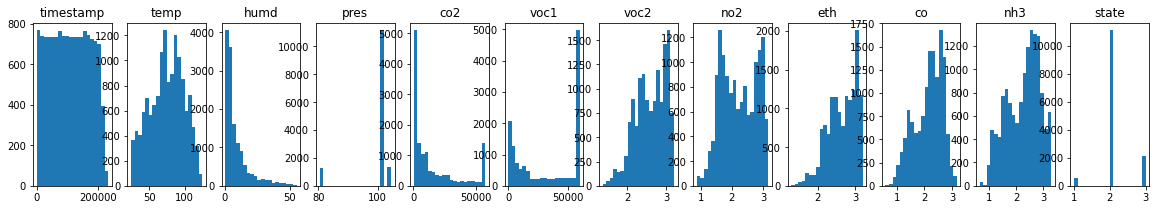

In [ ]:
### Examine the histograms of all the data

# Create subplots
num_hists = len(header)
fig, axs = plt.subplots(1, num_hists, figsize=(20,3))

# Create histogram for each category of data
for i in range(num_hists):
  _ = axs[i].hist(raw_data_np[:,i], bins=20, histtype='bar')
  axs[i].title.set_text(header[i])

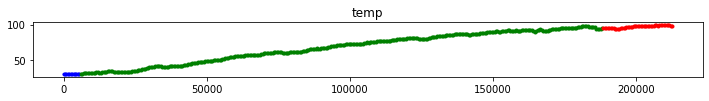

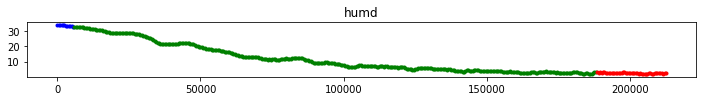

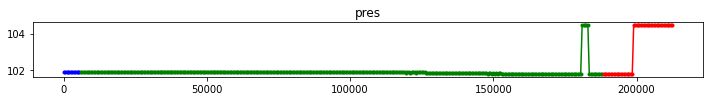

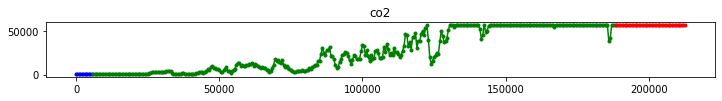

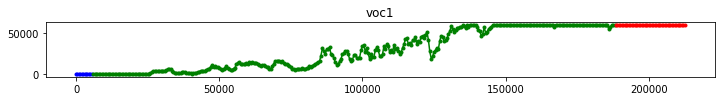

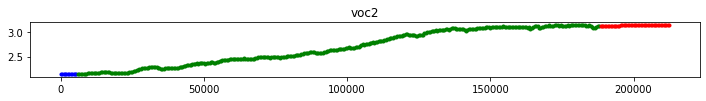

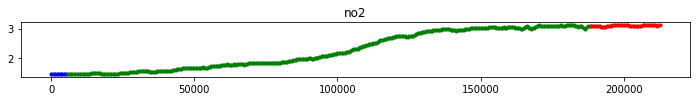

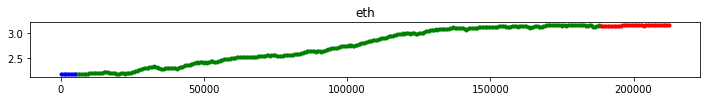

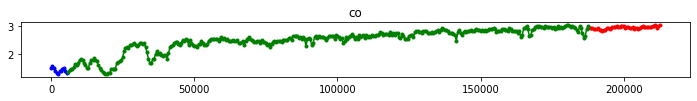

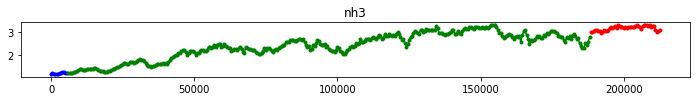

In [ ]:
### Choose 1 sample and plot the gas data over time

sample_idx = 0
num_sensors = len(header) - 2

# Calculate number of readings in each state
num_background = np.sum(raw_data[sample_idx][:,-1] == 1)
num_toasting = np.sum(raw_data[sample_idx][:,-1] == 2)
num_burnt = np.sum(raw_data[sample_idx][:,-1] == 3)

# Get x-axis (time data) for each state
t_background = raw_data[sample_idx][:num_background, 0]
t_toasting = raw_data[sample_idx][num_background:(num_background + num_toasting), 0]
t_burnt = raw_data[sample_idx][(num_background + num_toasting):, 0]
t_series = [t_background, t_toasting, t_burnt]

# Plot data from each sensor
for sensor_idx in range(1, num_sensors + 1):

  # Get the label
  label = header[sensor_idx]

  # Get the y-axis (sensor reading)
  y_background = raw_data[sample_idx][:num_background, sensor_idx]
  y_toasting = raw_data[sample_idx][num_background:(num_background + num_toasting), sensor_idx]
  y_burnt = raw_data[sample_idx][(num_background + num_toasting):, sensor_idx]
  y_series = [y_background, y_toasting, y_burnt]

  # Plot each sensor
  plt.figure(figsize=(12,1))
  plt.plot(t_background, y_background, color='blue', marker='.')
  plt.plot(t_toasting, y_toasting, color='green', marker='.')
  plt.plot(t_burnt, y_burnt, color='red', marker='.')
  plt.title(label)

## Step 3: Prepare and split the data

In [ ]:
### Construct X (gas data) and y (time until burn) regression data

X = []
y = []

# Loop through all the raw samples
for idx in range(len(raw_data)):

  # Find the time at which the burning was detected
  burnt_idxs = np.where(raw_data[idx][:, STATE_IDX] == BURNT_STATE_NUM)[0]
  burn_timestamp = raw_data[idx][min(burnt_idxs), 0]

  # Create sliding window gas data (without timestamp and state) to X and "time until burn" to y
  win_idx = 0
  while win_idx < len(raw_data[idx]):

    # Check to make sure we're not exceeding the sequence
    if win_idx + X_WINDOW_LEN > len(raw_data[idx]):
      break

    # Copy window to our X dataset
    window = raw_data[idx][win_idx:(win_idx + X_WINDOW_LEN), :]
    X.append(window)
    
    # Copy time until burned (at the end of the window) as our ground truth values
    y.append(burn_timestamp - raw_data[idx][(win_idx + X_WINDOW_LEN - 1), 0])

    # Mover window up by our stride
    win_idx += X_WINDOW_STRIDE

# Turn X and y into numpy arrays (and scale Y)
X = np.array(X)
y = np.array(y) / Y_SCALE

# Check shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6575, 20, 12)
y shape: (6575,)


In [ ]:
### Curate the columns

# Columns to drop
# Originally: remove timestamp, pressure (it's useless), and state columns.
# Try removing others to see if it affects MSE loss!
cols_to_delete = [TIME_IDX, PRES_IDX, STATE_IDX] # Default: keep all gas data
# cols_to_delete = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] # Purposely bad: only keep temperature
# cols_to_delete = [TIME_IDX, PRES_IDX, CO2_IDX, VOC1_IDX, NH3_IDX, STATE_IDX] 

# Remove column(s) from dataset
X_curated = np.delete(X, cols_to_delete, axis=2)

# Drop timestamp, state, and pressure from header
channel_names = [name for n, name in enumerate(header) if n not in cols_to_delete]

print(channel_names)
print(X_curated.shape)

['temp', 'humd', 'co2', 'voc1', 'voc2', 'no2', 'eth', 'co', 'nh3']
(6575, 20, 9)


In [ ]:
### Shuffle and split dataset

# Get number of samples
num_samples = X_curated.shape[0]

# Use a seed in case we want to recreate the exact results
random.seed(SEED)

# Shuffle our dataset
X_y = list(zip(list(X_curated), list(y)))
random.shuffle(X_y)
X_all, y_all = zip(*X_y)

# Calculate number of validation and test samples to put aside (round down)
num_samples_test = int(TEST_RATIO * num_samples)

# The first `num_samples_test` samples of the shuffled list becomes the test set
X_test = X_all[:num_samples_test]
y_test = y_all[:num_samples_test]

# The remaining samples become the training set
X_train = X_all[num_samples_test:]
y_train = y_all[num_samples_test:]

# Convert data to Numpy arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Print shapes of our sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5260, 20, 9)
y_train shape: (5260,)
X_test shape: (1315, 20, 9)
y_test shape: (1315,)


In [ ]:
### Function to calculate dataset metrics (mean, std dev, etc.) for each channel
def calc_metrics(X, ignore_first_col=False):

  # Calculate means, standard deviations, and ranges
  means = np.mean(X, axis=0)
  std_devs = np.std(X, axis=0)
  mins = np.min(X, axis=0)
  ranges = np.ptp(X, axis=0)

  # Drop the first column if requested
  if ignore_first_col:
    return (means[1:], std_devs[1:], mins[1:], ranges[1:])
  else:
    return (means, std_devs, mins, ranges)

In [ ]:
### Compute the metrics of the training data

# Compute per-channel metrics
X_train_flattened = np.reshape(X_train, 
                               (X_train.shape[0] * X_train.shape[1], X_train.shape[2]))
(means, std_devs, mins, ranges) = calc_metrics(X_train_flattened, ignore_first_col=False)

# Print out the results
print(channel_names)
print("Means:", [float("{:.4f}".format(x)) for x in means])
print("Std devs:", [float("{:.4f}".format(x)) for x in std_devs])
print("Mins:", [float("{:.4f}".format(x)) for x in mins])
print("Ranges:", [float("{:.4f}".format(x)) for x in ranges])

['temp', 'humd', 'co2', 'voc1', 'voc2', 'no2', 'eth', 'co', 'nh3']
Means: [75.3313, 8.7041, 15477.0725, 32948.1576, 2.597, 2.214, 2.6482, 2.165, 2.2881]
Std devs: [23.2161, 9.2682, 18607.4334, 24440.5729, 0.3711, 0.5537, 0.373, 0.4879, 0.5875]
Mins: [24.7, 0.44, 400.0, 0.0, 1.38, 0.87, 1.28, 0.59, 0.64]
Ranges: [100.44, 55.01, 56930.0, 60000.0, 1.81, 2.3, 1.92, 2.58, 2.66]


## Step 4: Perform preprocessing (standardization)

In [ ]:
### Function to perform standardization for a given set of data
def standardize_data(a, mean, std_dev):
  standardized_a = (a - mean) / std_dev
  return standardized_a

In [ ]:
### Standardize each channel (do NOT standardize the timestamp channel!)

# Initialize standardized data arrays
X_train_std = np.zeros(X_train.shape)
X_test_std = np.zeros(X_test.shape)

# Go through each channel in the training data
for i in range(len(channel_names)):
  X_train_std[:,:,i] = standardize_data(X_train[:,:,i], 
                                        means[i], 
                                        std_devs[i])

# Go through each channel in the test data. Notice that we use the same means
# and standard deviations that we calculated from the training data!
for i in range(len(channel_names)):
  X_test_std[:,:,i] = standardize_data(X_test[:,:,i], 
                                       means[i], 
                                       std_devs[i])
    
# Print shapes
print("X_train_std shape:", X_train_std.shape)
print("X_test_std shape:", X_test_std.shape)

X_train_std shape: (5260, 20, 9)
X_test_std shape: (1315, 20, 9)


['temp', 'humd', 'co2', 'voc1', 'voc2', 'no2', 'eth', 'co', 'nh3']
Means: [0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0]
Std devs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Mins: [-2.1809, -0.8917, -0.8103, -1.3481, -3.2798, -2.4271, -3.6676, -3.2283, -2.8052]
Ranges: [4.3263, 5.9353, 3.0595, 2.4549, 4.878, 4.1536, 5.1468, 5.2882, 4.5275]


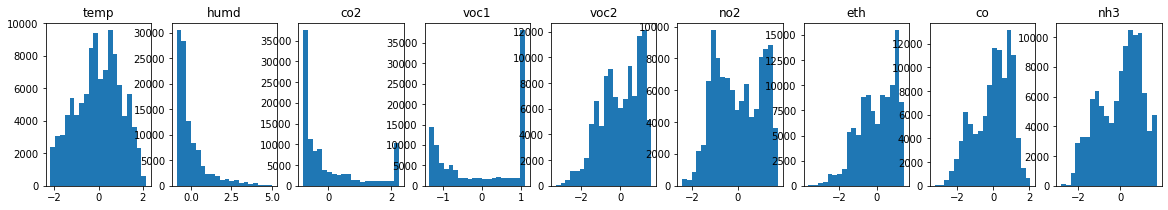

In [ ]:
### Examine the metrics and histograms of the newly standardized data

# Compute metrics of newly standardized data
X_train_std_flattened = np.reshape(X_train_std, 
                                (X_train_std.shape[0] * X_train_std.shape[1], X_train_std.shape[2]))
(means_new, std_devs_new, mins_new, ranges_new) = calc_metrics(X_train_std_flattened)

# Print out the results
print(channel_names)
print("Means:", [float("{:.4f}".format(x)) for x in means_new])
print("Std devs:", [float("{:.4f}".format(x)) for x in std_devs_new])
print("Mins:", [float("{:.4f}".format(x)) for x in mins_new])
print("Ranges:", [float("{:.4f}".format(x)) for x in ranges_new])

# Create subplots
num_hists = len(channel_names)
fig, axs = plt.subplots(1, num_hists, figsize=(20,3))

# Create histogram for each category of data
for i in range(num_hists):
  _ = axs[i].hist(X_train_std_flattened[:,i], bins=20, histtype='bar')
  axs[i].title.set_text(channel_names[i])

## Step 5: Examine Relationships with Correlation

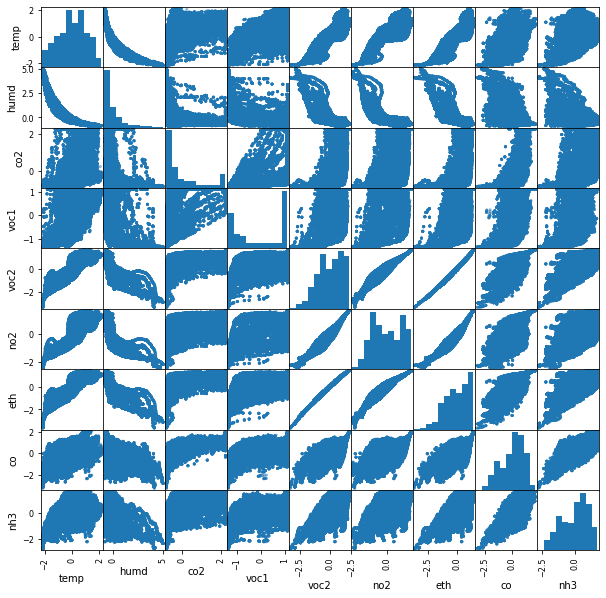

In [ ]:
### Plot scatter matrix to look for correlation (linear relationships)

# Convert NumPy array to Pandas DataFrame
X_train_df = pd.DataFrame(X_train_std_flattened, columns=channel_names)

# Create scatter matrix
sm = pd.plotting.scatter_matrix(X_train_df, figsize=(10, 10))

In [ ]:
### View raw Pearson correlation coefficients (PCCs)
pearson_corr = X_train_df.corr(method='pearson')
pearson_corr

,temp,humd,co2,voc1,voc2,no2,eth,co,nh3
temp,1.000000,-0.838103,0.497846,0.678568,0.864804,0.877069,0.869972,0.568233,0.583092
humd,-0.838103,1.000000,-0.336860,-0.486457,-0.741704,-0.730868,-0.760364,-0.463495,-0.520166
co2,0.497846,-0.336860,1.000000,0.677326,0.628155,0.589617,0.617281,0.695419,0.585893
voc1,0.678568,-0.486457,0.677326,1.000000,0.714422,0.670325,0.715905,0.717818,0.697356
voc2,0.864804,-0.741704,0.628155,0.714422,1.000000,0.964359,0.997854,0.764481,0.707364
no2,0.877069,-0.730868,0.589617,0.670325,0.964359,1.000000,0.963615,0.655513,0.599508
eth,0.869972,-0.760364,0.617281,0.715905,0.997854,0.963615,1.000000,0.759453,0.700639
co,0.568233,-0.463495,0.695419,0.717818,0.764481,0.655513,0.759453,1.000000,0.811488
nh3,0.583092,-0.520166,0.585893,0.697356,0.707364,0.599508,0.700639,0.811488,1.000000


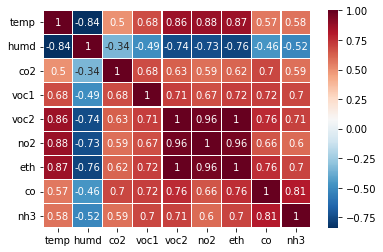

In [ ]:
### View heatmap of PCCs
sb.heatmap(pearson_corr, 
            xticklabels=pearson_corr.columns,
            yticklabels=pearson_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.2)

## Step 6: Store preprocessed data in CSV files

In [ ]:
### Delete output directory (if it exists) and recreate it
if os.path.exists(OUT_PATH):
  shutil.rmtree(OUT_PATH)
os.makedirs(os.path.join(OUT_PATH, TRAIN_DIR))
os.makedirs(os.path.join(OUT_PATH, TEST_DIR))

In [ ]:
# Add timestamp function
def add_timestamps(X, sample_rate):
  
  # Add timestamps to data
  X_with_timestamp = []
  for idx in range(X.shape[0]):
    sample = []
    for t in range(X.shape[1]):
      timestamp = t * sample_rate
      reading = np.insert(X[idx, i, :], 0, timestamp, axis=0)
      sample.append(reading)
    X_with_timestamp.append(np.array(sample))

  # Convert to Numpy array
  X_with_timestamp = np.array(X_with_timestamp)

  return X_with_timestamp

In [ ]:
### Add timestamps to data

# Add timestamps
X_train_csv = add_timestamps(X_train_std, sample_rate)
X_test_csv = add_timestamps(X_test_std, sample_rate)

# Add timestamp to header
channel_names_csv = ["timestamp"] + channel_names

# Print shapes
print(channel_names_csv)
print("X train CSV:", X_train_csv.shape)
print("X test CSV:", X_test_csv.shape)

['timestamp', 'temp', 'humd', 'co2', 'voc1', 'voc2', 'no2', 'eth', 'co', 'nh3']
X train CSV: (5260, 20, 10)
X test CSV: (1315, 20, 10)


In [ ]:
### Function to write header and data to CSV file to given directory
def write_csv_data(header, data, filepath):
    with open(filepath, 'w') as f:
      csv_writer = csv.writer(f, delimiter=',')
      csv_writer.writerow(header)
      for i in range(data.shape[0]):
        csv_writer.writerow(data[i])

In [ ]:
### Write training and test data to .csv files in separate directories

# Write out training data
dir_path = os.path.join(OUT_PATH, TRAIN_DIR)
for idx in range(len(y_train)):
  label = str(round(y_train[idx]))
  id = uuid.uuid4().hex
  filename = label + "." + id + ".csv"
  filepath = os.path.join(OUT_PATH, TRAIN_DIR, filename)
  write_csv_data(channel_names_csv, X_train_csv[idx], filepath)

# Write out test data
dir_path = os.path.join(OUT_PATH, TEST_DIR)
for idx in range(len(y_test)):
  label = str(round(y_test[idx]))
  id = uuid.uuid4().hex
  filename = label + "." + id + ".csv"
  filepath = os.path.join(OUT_PATH, TEST_DIR, filename)
  write_csv_data(channel_names_csv, X_test_csv[idx], filepath)

In [ ]:
### Zip output directory
%cd {OUT_PATH}
!zip -FS -r -q {OUT_ZIP} *
%cd {HOME_PATH}

/content/out
/content


## Step 7: Train possible model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, DepthwiseConv1D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

In [ ]:
### Build and train the model

# Settings (use L1(0.1) for feature importance ranking and L1(0.001) for real training)
bias = True
kernel_reg = tf.keras.regularizers.L1(0.1)
bias_reg = tf.keras.regularizers.L1(0.1)
activity_reg = None
batch_size = 32
epochs = 200

# Get dimensions
n_channels = X_train_std.shape[2]

# A sequential model is a linear stack of layers
model = Sequential()

# Model (match what's in Edge Impulse)
model.add(Dense(80,
                use_bias=bias,
                kernel_regularizer=kernel_reg,
                bias_regularizer=bias_reg,
                activity_regularizer=activity_reg,
                activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(40,
                activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1,
                activation='linear'))

# Configure the model's training settings (match what's in Edge Impulse)
opt = Adam(learning_rate=0.005,
           beta_1=0.9,
           beta_2=0.999)
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

# Flatten dataset (to mimic Edge Impulse)
X_train_reshape = np.reshape(X_train_std, (X_train_std.shape[0], X_train_std.shape[1] * X_train_std.shape[2]))

history = model.fit(X_train_reshape, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/200
132/132 [==============================] - 1s 4ms/step - loss: 4683.3145 - mse: 4569.7065 - mae: 53.7670 - val_loss: 1855.3148 - val_mse: 1735.9003 - val_mae: 33.6047
Epoch 2/200
132/132 [==============================] - 1s 5ms/step - loss: 1616.9485 - mse: 1494.3103 - mae: 29.4532 - val_loss: 950.4177 - val_mse: 825.8293 - val_mae: 22.5313
Epoch 3/200
132/132 [==============================] - 1s 5ms/step - loss: 1168.5833 - mse: 1043.6406 - mae: 24.7159 - val_loss: 763.4654 - val_mse: 638.7752 - val_mae: 19.3270
Epoch 4/200
132/132 [==============================] - 1s 8ms/step - loss: 1055.0354 - mse: 930.7935 - mae: 23.4844 - val_loss: 672.8232 - val_mse: 549.3535 - val_mae: 17.6931
Epoch 5/200
132/132 [==============================] - 0s 3ms/step - loss: 984.2499 - mse: 861.4906 - mae: 22.3750 - val_loss: 610.4094 - val_mse: 487.9468 - val_mae: 17.0161
Epoch 6/200
132/132 [==============================] - 1s 8ms/step - loss: 934.6805 - mse: 812.9840 - mae: 21.9599 -

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 80)                14480     
                                                                 
 dropout_24 (Dropout)        (None, 80)                0         
                                                                 
 dense_37 (Dense)            (None, 40)                3240      
                                                                 
 dropout_25 (Dropout)        (None, 40)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 41        
                                                                 
Total params: 17,761
Trainable params: 17,761
Non-trainable params: 0
_________________________________________________________________
None


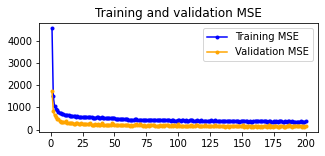

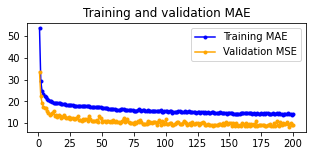

In [ ]:
### Plot training curves

print(model.summary())

# Extract accuracy and loss values (in list form) from the history
mse = history.history['mse']
val_mse = history.history['val_mse']
mae = history.history['mae']
val_mae = history.history['val_mae']

# Create a list of epoch numbers
epochs = range(1, len(mse) + 1)

# Plot training and validation MSE values over time
plt.figure(figsize=(5, 2))
plt.plot(epochs, mse, color='blue', marker='.', label='Training MSE')
plt.plot(epochs, val_mse, color='orange', marker='.', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

# Plot training and validation MAE over time
plt.figure(figsize=(5, 2))
plt.plot(epochs, mae, color='blue', marker='.', label='Training MAE')
plt.plot(epochs, val_mae, color='orange', marker='.', label='Validation MSE')
plt.title('Training and validation MAE')
plt.legend()
plt.show()

In [ ]:
### Aggregate first layer weights for each channel

# Get weights (without the bias terms)
weights = model.layers[0].get_weights()[0]

# Take mean of squares of each set of weights (i.e. weights feeding into nodes for each feature)
mean_sq = np.sum(np.square(weights), axis=1) / weights.shape[1]

# Aggregate (RMS) the value for each channel across the series of features
# We want to get one RMS value for each channel
rms = np.zeros(len(channel_names))
for i, name in enumerate(channel_names):
  channel_means = mean_sq[i::len(channel_names)]
  rms[i] = np.sqrt(np.sum(channel_means) / len(channel_means))

# Normalize the RMS scores
norm_rms = rms / np.sum(rms)

# Sort features by importance ranking (RMS)
zip_features = zip(channel_names, rms, norm_rms)
zip_features = sorted(zip_features, key = lambda x: x[1], reverse=True)

# Print feature importance
print("Feature importance (highest to lowest)")
print("Feature name\t:\tRMS value\t:\tNormalized RMS")
for name, rms, norm_rms in zip_features:
  print(name, "\t\t:\t{:.5f}".format(rms.round(5)), "\t:\t{:.5f}".format(norm_rms.round(5)))

Feature importance (highest to lowest)
Feature name	:	RMS value	:	Normalized RMS
no2 		:	0.12586 	:	0.17290
temp 		:	0.11789 	:	0.16195
co 		:	0.09213 	:	0.12656
voc2 		:	0.07268 	:	0.09984
nh3 		:	0.07104 	:	0.09760
humd 		:	0.06763 	:	0.09291
eth 		:	0.06756 	:	0.09282
voc1 		:	0.06268 	:	0.08610
co2 		:	0.05045 	:	0.06931


Reminder about gas sensors:

* Grove BME680: `temp, humd`
* Grove SGP30: `co2, voc1`
* Grove Multichannel Gas Sensor: `voc2, no, eth, co`
* Ammonia sensor: `nh3`

## Step 8: Run some tests

In [ ]:
### Test on the test set

# Reshape test set to mimic Edge Impulse
X_test_reshape = np.reshape(X_test_std, (X_test_std.shape[0], X_test_std.shape[1] * X_test_std.shape[2]))

# Make predictions
y_pred = model.predict(X_test_reshape).flatten()

# See how close we were
print("Predicted vs. True")
for i in range(10):
  print(round(y_pred[i], 3), "vs.", round(y_test[i], 3))

Predicted vs. True
121.029 vs. 120.5
137.978 vs. 159.0
53.36 vs. 63.0
149.097 vs. 154.5
-31.85 vs. -43.0
127.293 vs. 131.0
109.639 vs. 112.0
137.165 vs. 131.5
89.478 vs. 92.0
72.15 vs. 64.0


In [ ]:
### Get MSE of test set (Edge Impulse MSE on original test set: 128.40)
print("MSE of test set:", tf.keras.losses.mean_squared_error(y_test, y_pred).numpy())

MSE of test set: 156.3956


In [ ]:
### Are we actually seeing some values less than 0?
np.sum(y_pred < 0)

232

(212, 20, 9)
(212,)


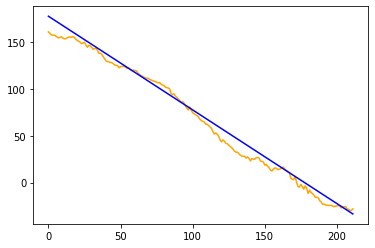

In [ ]:
### Create test batch from a single sequence

test_idx = 1

# Create sliding window gas data (without timestamp and state) to X and "time until burn" to y
win_idx = 0
X_test_seq = []
y_test_seq = []
while win_idx < len(raw_data[test_idx]):

  # Check to make sure we're not exceeding the sequence
  if win_idx + X_WINDOW_LEN > len(raw_data[test_idx]):
    break

  # Generate window, remove unwanted columns
  window = raw_data[test_idx][win_idx:(win_idx + X_WINDOW_LEN), :]
  window = np.delete(window, cols_to_delete, axis=1)

  # Perform standardization and save to our test set
  window = (window - means) / std_devs
  X_test_seq.append(window)
  
  # Copy time until burned (at the end of the window) as our ground truth values
  y_test_seq.append(burn_timestamp - raw_data[test_idx][(win_idx + X_WINDOW_LEN - 1), 0])

  # Mover window up by our stride
  win_idx += X_WINDOW_STRIDE

# Turn into Numpy arrays
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq) / Y_SCALE

# View shapes
print(X_test_seq.shape)
print(y_test_seq.shape)

# Predict time until burnt for test sequence
X_test_reshape = np.reshape(X_test_seq, (X_test_seq.shape[0], X_test_seq.shape[1] * X_test_seq.shape[2]))
y_pred = model.predict(X_test_reshape).flatten()

# Plot actual and predicted times
plt.plot(y_pred, color='orange')
plt.plot(y_test_seq, color='blue')

In [ ]:
### Read new sequence from CSV (if available)

test_csv = "/content/freezer.1660169618429.csv"

# Store header, raw data, and number of lines found in each .csv file
header = None

sample_data = []

# Read the .csv file
with open(test_csv) as f:
  csv_reader = csv.reader(f, delimiter=',')

  # Read each line
  valid_line_counter = 0
  for line_count, line in enumerate(csv_reader):

    # Check header
    if line_count == 0:

      # Record first header as our official header for all the data
      if header == None:
        header = line

      # Check to make sure subsequent headers match the original header
      if header == line:
        filenames.append(filename)
      else:
        print("Error: Headers do not match. Skipping", filename)
        break

    # Construct raw data array, make sure number of elements match number of header labels
    else:
      if len(line) == len(header):
        sample_data.append(line)
      else:
        print("Error: Data length does not match header length. Skipping line.")
        continue

# Turn into sequence
raw_seq = np.array(sample_data).astype('float')

# Print shape
print(raw_seq.shape)

FileNotFoundError: ignored

(203, 20, 9)
(203,)
7/7 [==============================] - 0s 3ms/step


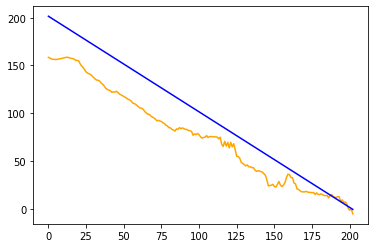

In [ ]:
### Do prediction on new sequence

# Create sliding window gas data (without timestamp and state) to X and "time until burn" to y
win_idx = 0
X_test_seq = []
y_test_seq = []
while win_idx < len(raw_seq):

  # Check to make sure we're not exceeding the sequence
  if win_idx + X_WINDOW_LEN > len(raw_seq):
    break

  # Generate window, remove unwanted columns
  window = raw_seq[win_idx:(win_idx + X_WINDOW_LEN), :]
  window = np.delete(window, cols_to_delete, axis=1)

  # Perform standardization and save to our test set
  window = (window - means) / std_devs
  X_test_seq.append(window)
  
  # Copy time until burned (at the end of the window) as our ground truth values
  y_test_seq.append(burn_timestamp - raw_seq[(win_idx + X_WINDOW_LEN - 1), 0])

  # Mover window up by our stride
  win_idx += X_WINDOW_STRIDE

# Turn into Numpy arrays
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq) / Y_SCALE

# View shapes
print(X_test_seq.shape)
print(y_test_seq.shape)

# Predict time until burnt for test sequence
X_test_reshape = np.reshape(X_test_seq, (X_test_seq.shape[0], X_test_seq.shape[1] * X_test_seq.shape[2]))
y_pred = model.predict(X_test_reshape).flatten()

# Plot actual and predicted times
plt.plot(y_pred, color='orange')
plt.plot(y_test_seq, color='blue')